In [1]:
import pandas as pd
import numpy as np
import datetime

import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC

In [2]:
team = 'Ninjas in Pyjamas'

In [3]:
results = pd.read_csv('results_info.csv')
events = pd.read_csv('events_info.csv')
ranks = pd.read_csv('rank_info.csv')

### Create a copy & preprocess results data

In [4]:
df = results
df.head()

,Unnamed: 0,date,event,map,team_1,team_2
0,0,2022-10-24,CCT North Europe Series 1,['Ancient'],Entropiq (14),1WIN (16)
1,1,2022-10-24,CCT Central Europe Series 3,['Vertigo'],ECLOT (16),FTW (12)
2,2,2022-10-24,CCT Central Europe Series 3,['Inferno'],FTW (16),ECLOT (14)
3,3,2022-10-24,WePlay Academy League Season 6,['Mirage'],Flames Ascent (10),MOUZ NXT (16)
4,4,2022-10-24,CCT Central Europe Series 3,['Nuke'],SC (6),HAVU (16)


In [5]:
# drop index col
df = df.drop(columns=['Unnamed: 0'])
events = events.drop(columns=['Unnamed: 0'])
ranks = ranks.drop(columns=['Unnamed: 0'])

In [6]:
# split date column into relevant time features
df.date=pd.to_datetime(df.date, format="%Y/%m/%d")

# df['day'] = df.date.dt.day
df['week'] = df.date.dt.week
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year

# # drop date column
# df = df.drop(columns=['date'])

C:\Users\assau\AppData\Local\Temp\ipykernel_9120\4058779900.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df.date.dt.week


In [7]:
# clean map column
df['map'] = df['map'].str.strip("[]'")

In [8]:
# split team 1 and team 2 columns
df[['team1_name', 'team1_score']] = df['team_1'].str.split('(', 1, expand=True)
df['team1_name'] = df['team1_name'].str.strip(" ")
df['team1_score'] = df['team1_score'].str.strip(")")
df[['team2_name', 'team2_score']] = df['team_2'].str.split('(', 1, expand=True)
df['team2_name'] = df['team2_name'].str.strip(" ")
df['team2_score'] = df['team2_score'].str.strip(")")

# drop raw columns
df = df.drop(columns=['team_1', 'team_2'])

In [9]:
# change datatype of column after splitting
df['week'] = df['week'].astype(int)
df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)
df['team1_score'] = df['team1_score'].astype(int)
df['team2_score'] = df['team2_score'].astype(int)

In [10]:
# function to determine winner
def winner(row):
    if row['team1_score'] > row['team2_score']:
        val = row['team1_name']
    else:
        val = row['team2_name']
    return val

In [11]:
# create feature 'winner'
df['winner'] = df.apply(winner, axis=1)
df.head(3)

,date,event,map,week,month,year,team1_name,team1_score,team2_name,team2_score,winner
0,2022-10-24,CCT North Europe Series 1,Ancient,43,10,2022,Entropiq,14,1WIN,16,1WIN
1,2022-10-24,CCT Central Europe Series 3,Vertigo,43,10,2022,ECLOT,16,FTW,12,ECLOT
2,2022-10-24,CCT Central Europe Series 3,Inferno,43,10,2022,FTW,16,ECLOT,14,FTW


In [12]:
# ## Discontinued due to poor performance

# # create feature days since
# today = datetime.date.today()

# def ds(row):
#     val = today - row['date'].date()
#     return val

# df['days_since'] = df.apply(ds, axis=1)
# df['days_since'] = df['days_since'].astype(str)
# df['days_since'] = df['days_since'].map(lambda x: x.rstrip(' days'))

In [13]:
# drop duplicates
df.drop_duplicates(inplace=True)

### Merge with event details

In [14]:
# add event details
df = df.merge(events, how='left', on='event')

In [15]:
# drop unwanted columns - undo if want duration of tourney
df = df.drop(columns=['start_end'])

In [16]:
df.head(3)

,date,event,map,week,month,year,team1_name,team1_score,team2_name,team2_score,winner,num_teams,prize,type,region
0,2022-10-24,CCT North Europe Series 1,Ancient,43,10,2022,Entropiq,14,1WIN,16,1WIN,24,"$50,000",Online,Europe (Online) |
1,2022-10-24,CCT North Europe Series 1,Ancient,43,10,2022,Entropiq,14,1WIN,16,1WIN,24,"$50,000",Online,Europe (Online) |
2,2022-10-24,CCT Central Europe Series 3,Vertigo,43,10,2022,ECLOT,16,FTW,12,ECLOT,24,"$50,000",Online,Europe (Online) |


In [17]:
### convert prize column appropriately
# reflect qualification as prize
df['prize_qual'] = df['prize']

def qual(row):
    if row['prize_qual'] == 'Other':
        val = 1
    else:
        val = 0
    return val

df['prize_qual'] = df.apply(qual, axis=1)

In [18]:
# reflect money as prize
df['prize'] = df['prize'].str.strip('$')
df['prize'] = df['prize'].str.replace(',', '')

def prize(row):
    if row['prize'] == 'Other':
        val = 0
    else:
        val = row['prize']
    return val

df['prize'] = df.apply(prize, axis=1)

df['prize'] = df['prize'].astype(float)

In [19]:
# create feature premium to represent tournament
keywords = ['IEM', 'ESL', 'BLAST']

# function
def prem(row):
    if any(word in row['event'] for word in keywords):
        val = 1
    else:
        val = 0
    return val
    
df['premium'] = df.apply(prem, axis=1)    

In [20]:
# understanding the different classification types
temp = df['type'].unique()
temp

array(['Online', 'Local LAN', 'Reg. LAN', nan, 'Intl. LAN', 'Major'],
      dtype=object)

In [21]:
# function to rename tournament types, use try because of ongoing events
def tournament_type(row):
    if row['type'] != 'Online':
        val = 1
    else:
        val = 0
    return val

df['lan'] = df.apply(tournament_type, axis=1)

# drop initial column
df = df.drop(columns=['type'])

In [22]:
# clean num_teams col
df['num_teams'] = df['num_teams'].str.replace('+', '')

C:\Users\assau\AppData\Local\Temp\ipykernel_9120\2556089188.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['num_teams'] = df['num_teams'].str.replace('+', '')


In [23]:
# drop final unwanted columns
df = df.drop(columns=['region'])

### Cleaning ranks data

In [24]:
ranks.head()

,Unnamed: 0.1,Unnamed: 0.1.1,team,points,players,date_start
0,0.0,0.0,['Liquid'],['(707 points)'],"['nitr0', 'NAF', 'EliGE', 'oSee', 'YEKINDAR']",24/10/2022
1,1.0,1.0,['Nouns'],['(39 points)'],"['cynic', 'Bwills', 'cxzi', 'nosraC', 'jeorges...",24/10/2022
2,2.0,2.0,['EG White'],['(30 points)'],"['djay', 'Jonji', 'ben1337', 'PwnAlone', 'viz']",24/10/2022
3,3.0,3.0,['EG Black'],['(23 points)'],"['RUSH', 'stanislaw', 'Walco', 'wiz', 'chop']",24/10/2022
4,4.0,4.0,['Iron Blood'],['(21 points)'],"['droid', 'shane', 'dare', 'snav', 'intra']",24/10/2022


In [25]:
# strip clean valuable columns
ranks['team'] = ranks['team'].str.strip("[]'")
ranks['points'] = ranks['points'].str.strip("[(points)]' ")
# change dtype since its a str
ranks['points'] = ranks['points'].astype(int)

In [26]:
# create week column to match to main df
ranks.date_start=pd.to_datetime(ranks.date_start, format="%d/%m/%Y")
ranks['week'] = ranks.date_start.dt.week
ranks['year'] = ranks.date_start.dt.year

C:\Users\assau\AppData\Local\Temp\ipykernel_9120\2371287148.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  ranks['week'] = ranks.date_start.dt.week


In [27]:
ranks.dtypes

Unnamed: 0.1             float64
Unnamed: 0.1.1           float64
team                      object
points                     int32
players                   object
date_start        datetime64[ns]
week                       int64
year                       int64
dtype: object

In [28]:
# function to pull ranking points
def opp_points(row):
    opponent = row['opp']
    year = row['year']
    week = row['week']
    try:
        val = ranks.loc[(ranks['week'] == week) & (ranks['year'] == year) & (ranks['team'] == opponent)]['points'].values[0]
        return val
    except:
        return None
    
# def points_diff(row):
#     year = row['year']
#     week = row['week']
#     try:
#         val = ranks.loc[(ranks['week'] == week) & (ranks['year'] == year) & (ranks['team'] == team)]['points'].values[0] - row['opp_points']
#         return val
#     except:
#         return None

def points_diff(row):
    year = row['year']
    week = row['week']
    val = ranks.loc[(ranks['week'] == week) & (ranks['year'] == year) & (ranks['team'] == team)]['points'].values[0] - row['opp_points']
    return val
 

In [29]:
# change dtypes
# df['days_since'] = df['days_since'].astype(int)
df['num_teams'] = df['num_teams'].astype(float)

### Prediction Model

In [30]:
# create a function to find all relevant entries
def pred(team):
    df2 = df
    df2 = df2.drop(columns=['date', 'event','month'])
    df2['opp'] = None
#     df2['diff'] = None
#     df2['opp_points'] = None
    for i in range(len(df)):
        if df2.loc[i]['team1_name'] == team:
            df2.at[df2.index[i], 'opp'] = df2.loc[i]['team2_name']
            if df2.loc[i]['team1_score'] - df2.loc[i]['team2_score'] > 0:
                df2.at[df2.index[i], 'won'] = 1
            else:
                df2.at[df2.index[i], 'won'] = 0
            
        elif df2.loc[i]['team2_name'] == team:
            df2.at[df2.index[i], 'opp'] = df2.loc[i]['team1_name']
            if df2.loc[i]['team2_score'] - df2.loc[i]['team1_score'] > 0:
                df2.at[df2.index[i], 'won'] = 1
            else:
                df2.at[df2.index[i], 'won'] = 0
            
    # retain only relevant rows
    df2 = df2.dropna()
    df2 = df2.reset_index(drop=True)
    
    # drop null values for final df
    df2['opp_points'] = df2.apply(opp_points, axis=1)
    df2 = df2.dropna()
    
    # drop columns for final df
    df2 = df2.drop(columns=['team1_name','team1_score','team2_name',
                           'team2_score', 'winner', 'opp'])
    
    # dummies for map feature
    df2 = pd.get_dummies(df2, columns=['map'],  drop_first=True)
    
    return df2    

In [31]:
# # create a function to find all relevant entries
# def pred(team):
#     df2 = df
#     df2 = df2.drop(columns=['date', 'event','month'])
#     df2['opp'] = None
# #     df2['diff'] = None
# #     df2['opp_points'] = None
#     for i in range(len(df)):
#         if df2.loc[i]['team1_name'] == team:
#             df2.at[df2.index[i], 'opp'] = df2.loc[i]['team2_name']
#             df2.at[df2.index[i], 'diff'] = df2.loc[i]['team1_score'] - df2.loc[i]['team2_score']
#         elif df2.loc[i]['team2_name'] == team:
#             df2.at[df2.index[i], 'opp'] = df2.loc[i]['team1_name']
#             df2.at[df2.index[i], 'diff'] = df2.loc[i]['team2_score'] - df2.loc[i]['team1_score']
            
#     # retain only relevant rows
#     df2 = df2.dropna()
#     df2 = df2.reset_index(drop=True)
    
#     # drop null values for final df
#     df2['opp_points'] = df2.apply(opp_points, axis=1)
#     df2 = df2.dropna()
    
#     # drop columns for final df
#     df2 = df2.drop(columns=['team1_name','team1_score','team2_name',
#                            'team2_score', 'winner', 'opp'])
    
#     # dummies for map feature
#     df2 = pd.get_dummies(df2, columns=['map'],  drop_first=True)
    
#     return df2    

## Predicting a specific team

In [32]:
## Uncomment and overwrite for convenient if necessary
# team = 'Ninjas in Pyjamas'

dfx = pred(team)
dfx['points_diff'] = dfx.apply(points_diff, axis=1)
dfx = dfx.drop(columns=['week', 'year'])

# we try to predict the feature 'diff' to determine the winner/handicap
target = 'won'
features = [i for i in dfx.columns if i not in [target]]

**Visualise target distribution, diff**

In [33]:
dfx['won'].unique()

array([1., 0.])

In [34]:
dfx

,num_teams,prize,prize_qual,premium,lan,won,opp_points,map_Cache,map_Cobblestone,map_Dust2,map_Inferno,map_Mirage,map_Nuke,map_Overpass,map_Train,map_Vertigo,points_diff
0,6.0,46900.0,0,0,1,1.0,11.0,0,0,0,0,0,0,0,0,1,313.0
1,6.0,46900.0,0,0,1,1.0,11.0,0,0,0,0,0,0,0,0,1,313.0
2,6.0,46900.0,0,0,1,1.0,11.0,0,0,0,1,0,0,0,0,0,313.0
3,6.0,46900.0,0,0,1,1.0,11.0,0,0,0,1,0,0,0,0,0,313.0
4,6.0,46900.0,0,0,1,1.0,10.0,0,0,0,0,0,0,0,0,1,314.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,16.0,2000000.0,0,0,1,1.0,188.0,0,0,0,1,0,0,0,0,0,468.0
181,5.0,0.0,1,0,0,0.0,344.0,0,0,0,0,0,0,0,1,0,311.0
182,5.0,0.0,1,0,0,0.0,181.0,0,0,0,1,0,0,0,0,0,474.0
183,5.0,0.0,1,0,0,1.0,16.0,0,1,0,0,0,0,0,0,0,639.0


<AxesSubplot:>

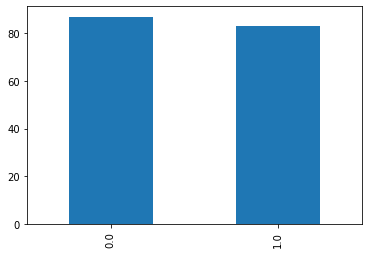

In [35]:
# Distribution of wins and losses
pd.value_counts(dfx['won']).plot.bar()

If distribution skewed, we may need to use suitable techniques like SMOTE.

In [36]:
# # Visualise our target distribution - round difference
# plt.figure(figsize=[14,14])
# # custom_bins = [i*3000 for i in range(60)]
# sns.displot(dfx['diff'], bins = 29)
# # sns.displot(dfx['diff'])
# plt.title('Round Difference Distribution')
# plt.xlim(-15, 15)
# plt.show()

**EDA on numerical variations**

In [37]:
dfx_eda = dfx[['num_teams', 'prize', 'opp_points', 'points_diff']]

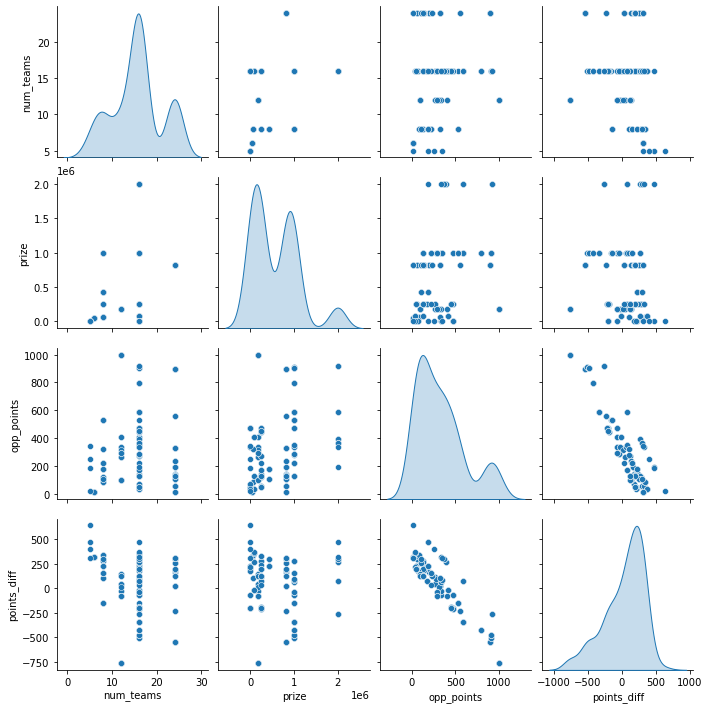

In [38]:
sns.pairplot(data=dfx_eda, diag_kind='kde')

Check to see distribution of numerical variables.\
In this case, 'prize' feature may be left skewed and can be normalised before modelling.

### Modelling

In [39]:
### function for model evaluation
def model_evaluation(pipe, params, model):
    
    gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=params, # what parameters values are we searching?
                  cv=5) 
    
    gs.fit(X_train, y_train)
    
    # Get predictions
    preds = gs.predict(X_test)
    
    best_params = gs.best_params_
    print('Best fitting parameters:', best_params)
    best_model = gs.best_estimator_
    
    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    # View confusion matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
    
    
    # Plot ROC graph
    plot_roc_curve(best_model, X_test, y_test)
    plt.plot([0, 1], [0, 1],
             label='baseline', linestyle='--')
    plt.legend();

    
    # Save results to Dataframe
    df = pd.DataFrame()
    df['model'] = [f'{model}']
    df['train_accuracy'] = round(gs.score(X_train, y_train), 5)
    df['test_accuracy'] = round(gs.score(X_test, y_test), 5)
    df['sensitivity'] =  round((tp / (tp + fn)), 5)
    df['specificity'] = round((tn / (tn + fp)), 5)
    df['precision'] = round((tp / (tp + fp)), 5)
    df['f1_score'] = round(f1_score(y_test, preds), 5)
    df['roc_auc_score'] = round(roc_auc_score(y_test, preds), 5)
    df['tn'] = tn
    df['fp'] = fp
    df['fn'] = fn
    df['tp'] = tp
    
    return df

In [40]:
# Empty list to store model outputs for later
df_all = []

### Log Reg
**Baseline Model**

In [41]:
# Feature Selection 
X = dfx[features]
y = dfx[target]
# Split data into test and train
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

In [42]:
# Create a LogisticRegression object
lr= LogisticRegression()
# Fit X and y 
lr.fit(X_train, y_train)

# Metrics to evaluate your model 
lr.score(X_train, y_train)

0.5955882352941176

In [43]:
lr.score(X_test, y_test)

0.5294117647058824

### Modelling with GridSearchCV

In [44]:
### Initialise a pipeline for log reg
pipe_lr = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression())
])

pipe_lr_params = {'lr__penalty': ['l2'],            
                  'lr__C': [1.0]}  

Best fitting parameters: {'lr__C': 1.0, 'lr__penalty': 'l2'}


,model,train_accuracy,test_accuracy,sensitivity,specificity,precision,f1_score,roc_auc_score,tn,fp,fn,tp
0,Logistic Regression,0.66176,0.58824,0.5,0.66667,0.57143,0.53333,0.58333,12,6,8,8


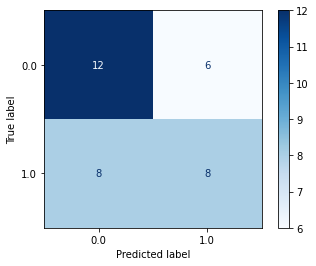

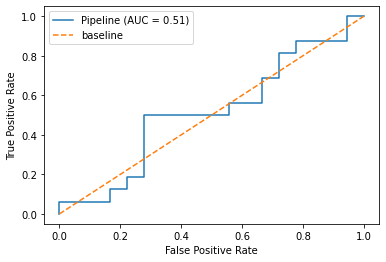

In [45]:
lr_eval = model_evaluation(pipe_lr, pipe_lr_params, 'Logistic Regression')
lr_eval

In [46]:
df_all.append(lr_eval)

### KNN

In [47]:
# Set up pipeline for knn
pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [48]:
pipe_knn_params = {
    'knn__n_neighbors': [30],                      
    'knn__algorithm': ['kd_tree'],                   
    'knn__weights': ['distance'],
    'knn__p': [1],                               
    'knn__leaf_size': [10],                        
}

Best fitting parameters: {'knn__algorithm': 'kd_tree', 'knn__leaf_size': 10, 'knn__n_neighbors': 30, 'knn__p': 1, 'knn__weights': 'distance'}


,model,train_accuracy,test_accuracy,sensitivity,specificity,precision,f1_score,roc_auc_score,tn,fp,fn,tp
0,K-Nearest Neighbors,0.99265,0.64706,0.625,0.66667,0.625,0.625,0.64583,12,6,6,10


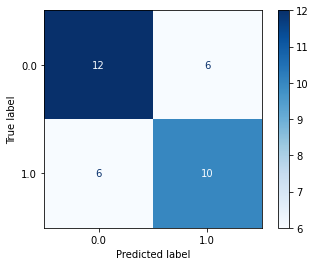

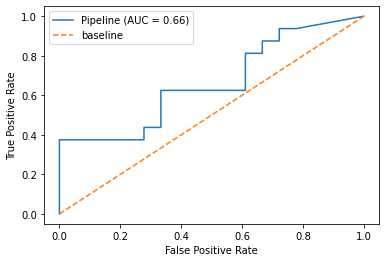

In [49]:
knn_eval = model_evaluation(pipe_knn, pipe_knn_params, 'K-Nearest Neighbors')
knn_eval

In [50]:
df_all.append(knn_eval)

### Random Forest

In [51]:
# Set up pipeline for rf
pipe_rf = Pipeline([
    ('rf', RandomForestClassifier())])

In [52]:
# Set up hyperparameters tuning                    
pipe_rf_params = {
    'rf__n_estimators':[300],                     
    'rf__max_depth':[20],                         
    'rf__min_samples_leaf': [1],                  
}

Best fitting parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 300}


,model,train_accuracy,test_accuracy,sensitivity,specificity,precision,f1_score,roc_auc_score,tn,fp,fn,tp
0,Random Forest Classifier,0.99265,0.70588,0.8125,0.61111,0.65,0.72222,0.71181,11,7,3,13


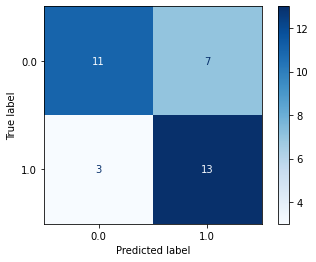

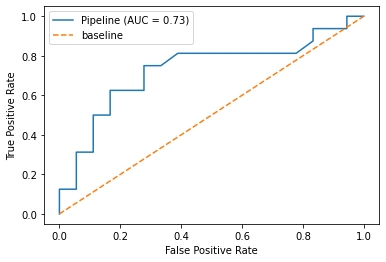

In [53]:
rf_eval = model_evaluation(pipe_rf, pipe_rf_params, 'Random Forest Classifier')
rf_eval

In [54]:
df_all.append(rf_eval)

### Ada Boost Classifier

In [55]:
# Set up pipeline for adaboost
pipe_ada = Pipeline([
    ('ada', AdaBoostClassifier())])

In [56]:
# Set up hyperparameters tuning                    
pipe_ada_params = {
    'ada__n_estimators':[100],                     
    'ada__learning_rate':[1],                                           
}

Best fitting parameters: {'ada__learning_rate': 1, 'ada__n_estimators': 100}


,model,train_accuracy,test_accuracy,sensitivity,specificity,precision,f1_score,roc_auc_score,tn,fp,fn,tp
0,Ada Boost Classifier,0.83824,0.67647,0.625,0.72222,0.66667,0.64516,0.67361,13,5,6,10


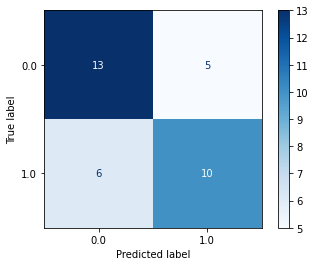

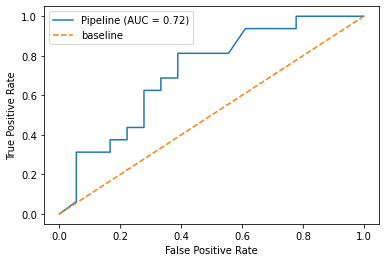

In [57]:
ada_eval = model_evaluation(pipe_ada, pipe_ada_params, 'Ada Boost Classifier')
ada_eval

In [58]:
df_all.append(ada_eval)

### Gradient Boost Classifier

In [59]:
# Set up pipeline for gradient boosting classifier
pipe_gb = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingClassifier())])

In [60]:
# Set up hyperparameters tuning                    
pipe_gb_params = {
    'gb__loss':['deviance'],                     
    'gb__learning_rate':[0.3],
    'gb__n_estimators': [3],
    'gb__subsample': [0.3]
}

Best fitting parameters: {'gb__learning_rate': 0.3, 'gb__loss': 'deviance', 'gb__n_estimators': 3, 'gb__subsample': 0.3}


,model,train_accuracy,test_accuracy,sensitivity,specificity,precision,f1_score,roc_auc_score,tn,fp,fn,tp
0,Gradient Boosting Classifier,0.64706,0.64706,0.5,0.77778,0.66667,0.57143,0.63889,14,4,8,8


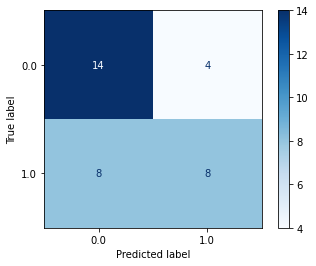

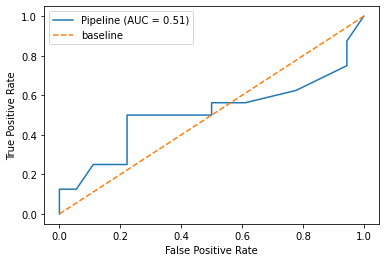

In [61]:
gb_eval = model_evaluation(pipe_gb, pipe_gb_params, 'Gradient Boosting Classifier')
gb_eval

In [62]:
df_all.append(gb_eval)

In [63]:
full_df = pd.concat(df_all)
full_df

,model,train_accuracy,test_accuracy,sensitivity,specificity,precision,f1_score,roc_auc_score,tn,fp,fn,tp
0,Logistic Regression,0.66176,0.58824,0.5000,0.66667,0.57143,0.53333,0.58333,12,6,8,8
0,K-Nearest Neighbors,0.99265,0.64706,0.6250,0.66667,0.62500,0.62500,0.64583,12,6,6,10
0,Random Forest Classifier,0.99265,0.70588,0.8125,0.61111,0.65000,0.72222,0.71181,11,7,3,13
0,Ada Boost Classifier,0.83824,0.67647,0.6250,0.72222,0.66667,0.64516,0.67361,13,5,6,10
0,Gradient Boosting Classifier,0.64706,0.64706,0.5000,0.77778,0.66667,0.57143,0.63889,14,4,8,8


## Summary

- Different models performed better for different teams
- Some models show promising results and might be worth investigating further.

### Project's Potential Pitfalls

Roster Changes
- Unlike some traditional sports like football or soccer, a change in one player is much more significant as it consist of 20% of the lineup.
- The impact may cause a substantial difference in a team's performance.
- Thus, there may be value in introducing a new feature to quantify such a change.

Team Dissolution
- It is possible in CS:GO to drop teams in their entirety and pick up a new roster.
- This compromises the integrity of the data as the team name would not adequately reflect the players that are playing under that banner.

Available features
- Due to the nature of the game, there isn't much useful features to proxy our estimates on.
- For example, shots (on target) & corners for soccer, throw-ins & free throws in basketball, XPM & GPM & wards in Dota 2

Data Availability
- Unable to scrape rank points for teams with an international core NOT in the top 30.
- Essentially making predictions for teams under this category impossible under the current model.